# Online convex programming example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Description of the testbed problem

Consider the following problem in two dimensions:

Feasible set $X$ is the unit circle

The sequence of convex functions is given as
$$
    c^t(x,y) = (x-x_1^{(t)})^2 + (y-y_1^{(t)})^2
$$

where we generate $x_1^{(t)}$ and $y_1^{(t)}$ from multivariate Gaussian density $\mathcal{N}(0,I)$.

The gradient is
$$
    \nabla c^t(x,y) = 
    \begin{pmatrix}
        2(x-x_1^{(t)}) \\
        2(y-y_1^{(t)})
    \end{pmatrix}
$$

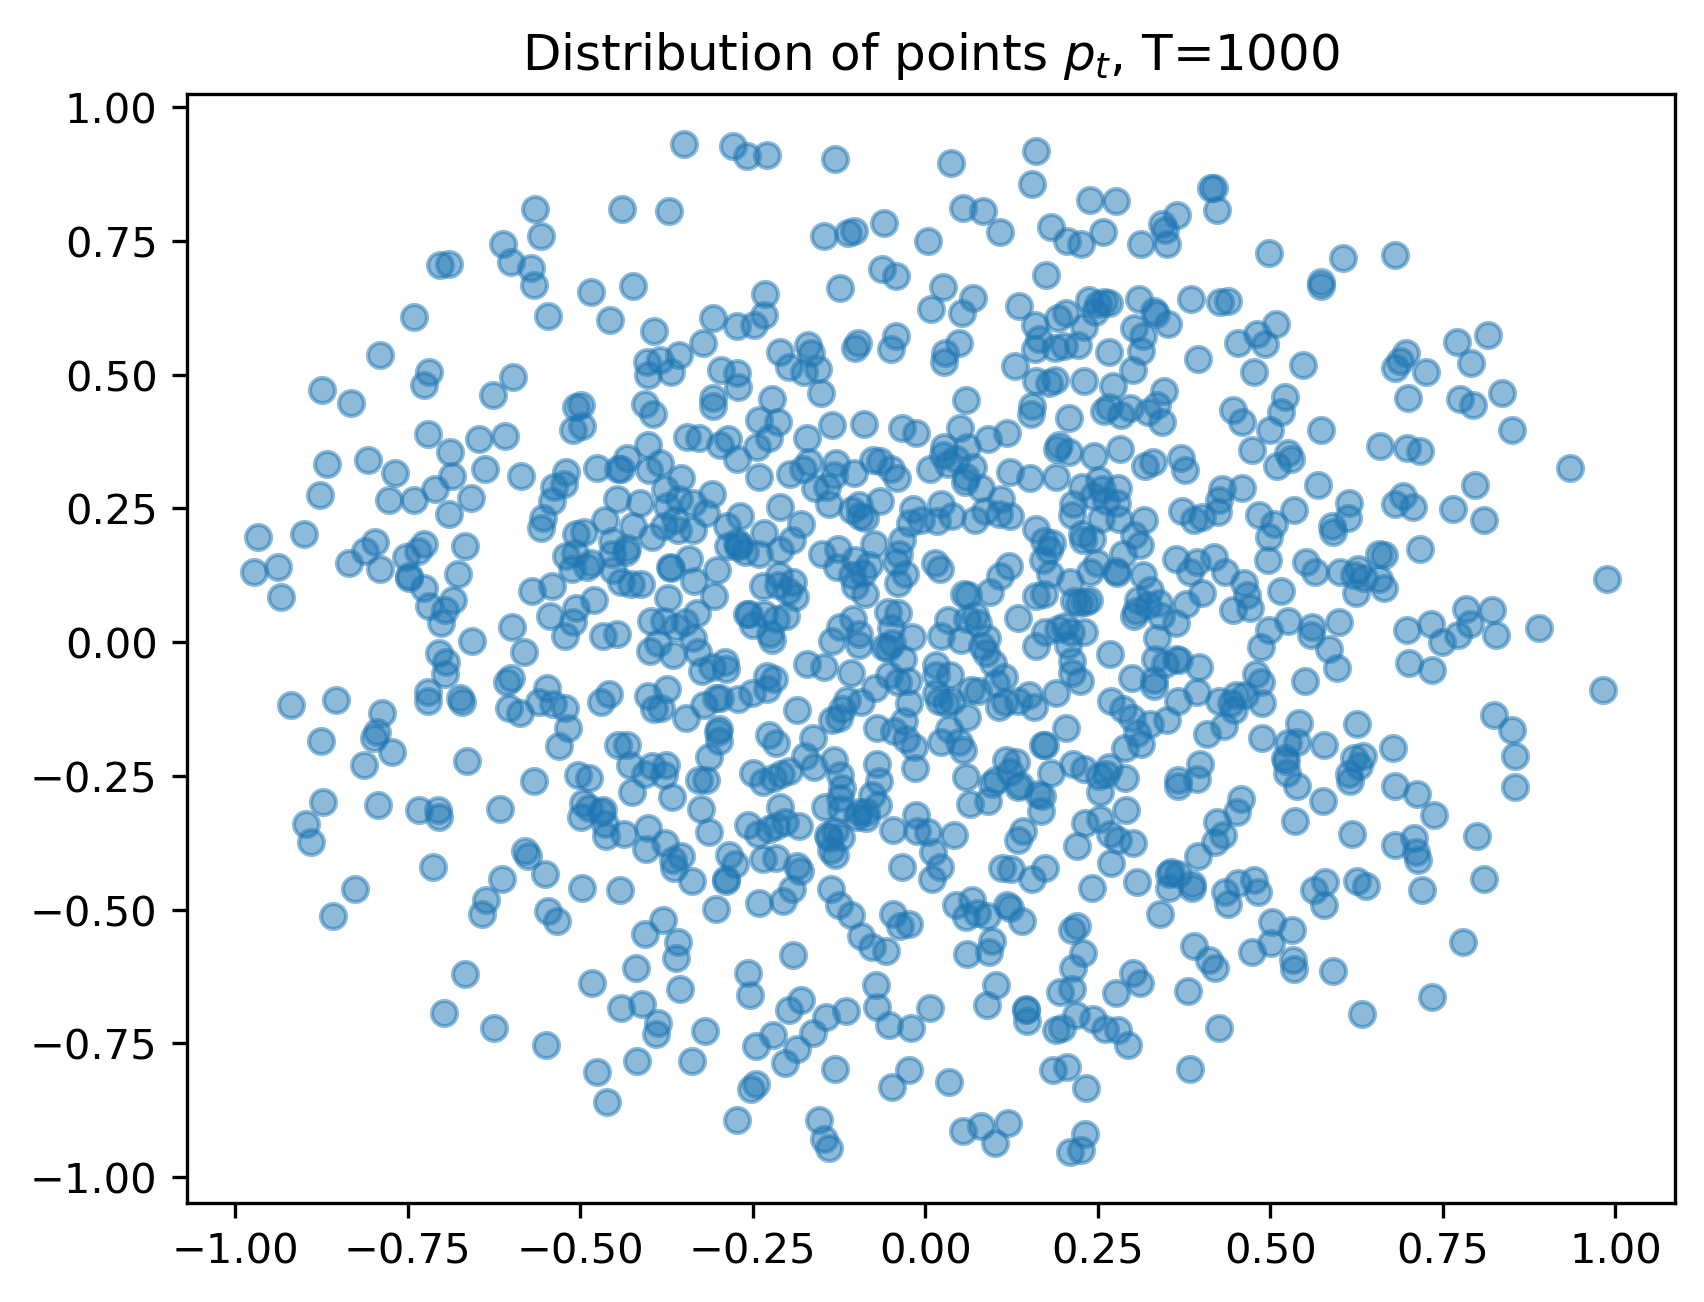

In [90]:
# generate the given series of functions
seq_length = 1000
dim = 2
samples = []
while len(samples) <= seq_length:
    sample = np.random.normal(loc=0,scale=0.5,size=dim)
    if np.linalg.norm(sample) <= 1:
        samples.append(sample)
samples = np.array(samples)
plt.title(r"Distribution of points $p_t$, T=1000")
plt.scatter(samples[:,0], samples[:,1],alpha=0.5)

In [91]:
from scipy.optimize import minimize

In [92]:
def grad(x, center):
    return (x-center)
def cost(x,center):
    return 0.5*(x-center)@(x-center)
# come up with a sequence of guesses via greedy projection
x0 = np.array([0,0])
x_t = [x0]
costs = []
for t,sample in enumerate(samples):
    # get the gradient of the given function
    this_step = 1/np.sqrt(t+1)
    last_x = x_t[-1]
    costs.append(cost(last_x,sample))
    this_grad = grad(last_x,sample)
    unproj_step = last_x - this_step*this_grad
    # do the projection
    result = minimize(
        fun = lambda x: (x-unproj_step) @ (x-unproj_step),
        x0 = np.array([0,0]),
        jac = lambda x: (x-unproj_step),
        constraints = ({
            'type':'ineq',
            'fun': lambda x: -x@x +1
        })
    )
    if result.status == 0:
        x_t.append(result.x)
    else:
        x_t.append(last_x)

In [93]:
# in comparison, try to find the best fixed vector
offline_result = minimize(
    fun = lambda x: sum([cost(x,center) for center in samples]),
    x0 = np.array([0,0]),
    jac = lambda x: sum([grad(x,center) for center in samples]),
    constraints = ({
            'type':'ineq',
            'fun': lambda x: -x@x +1
        }),
    method='SLSQP'
)
print(offline_result)
offline_x = offline_result.x

x=np.mean(samples,axis=0)
print(x)
#print(np.sum(samples,axis=0)/np.linalg.norm(np.sum(samples,axis=0)))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 166.80375835301308
       x: [-5.863e-03  1.039e-02]
     nit: 2
     jac: [-5.863e-03  1.039e-02]
    nfev: 5
    njev: 2
[-0.00585746  0.01037849]


In [94]:
# stuff for the bounds
F_norm = 1
grad_bound = 1
hess_bound = 2

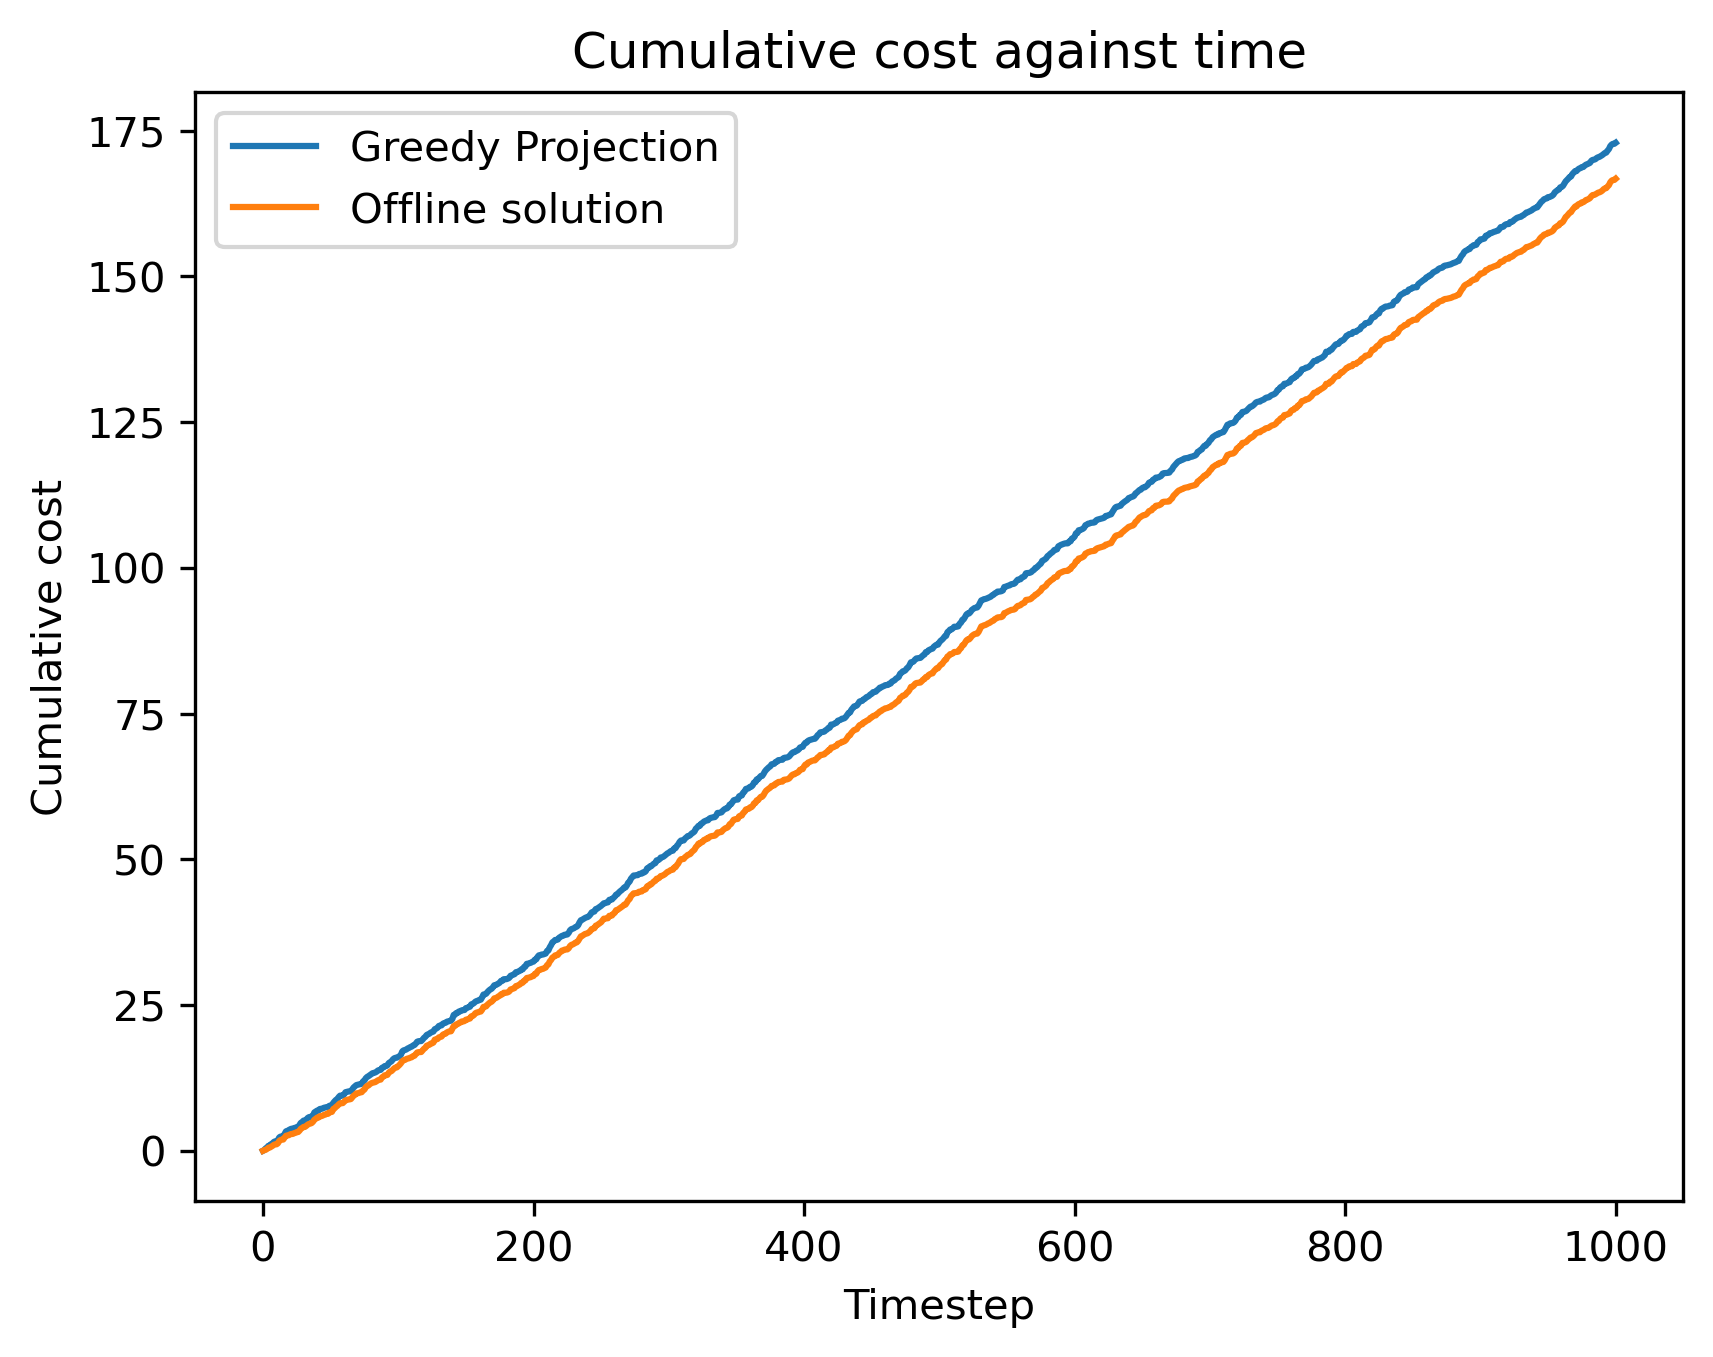

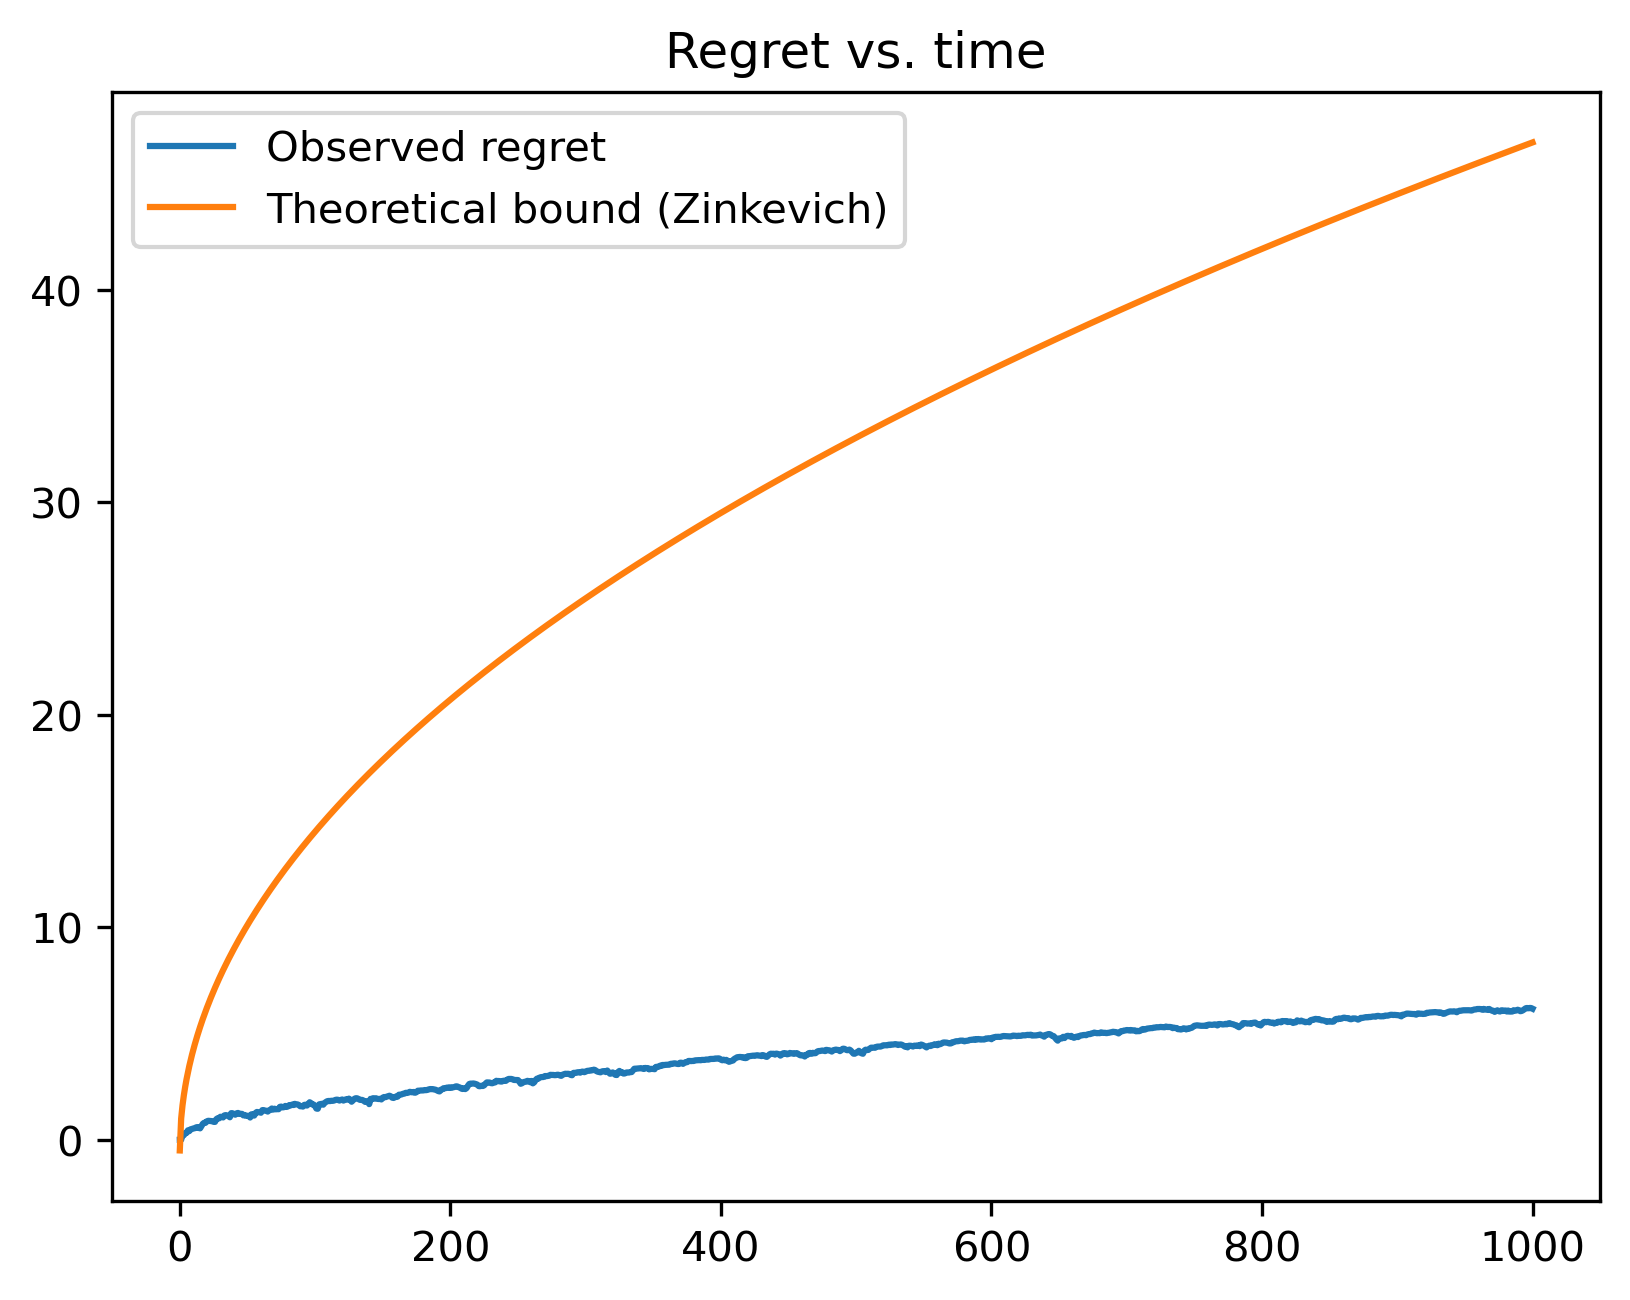

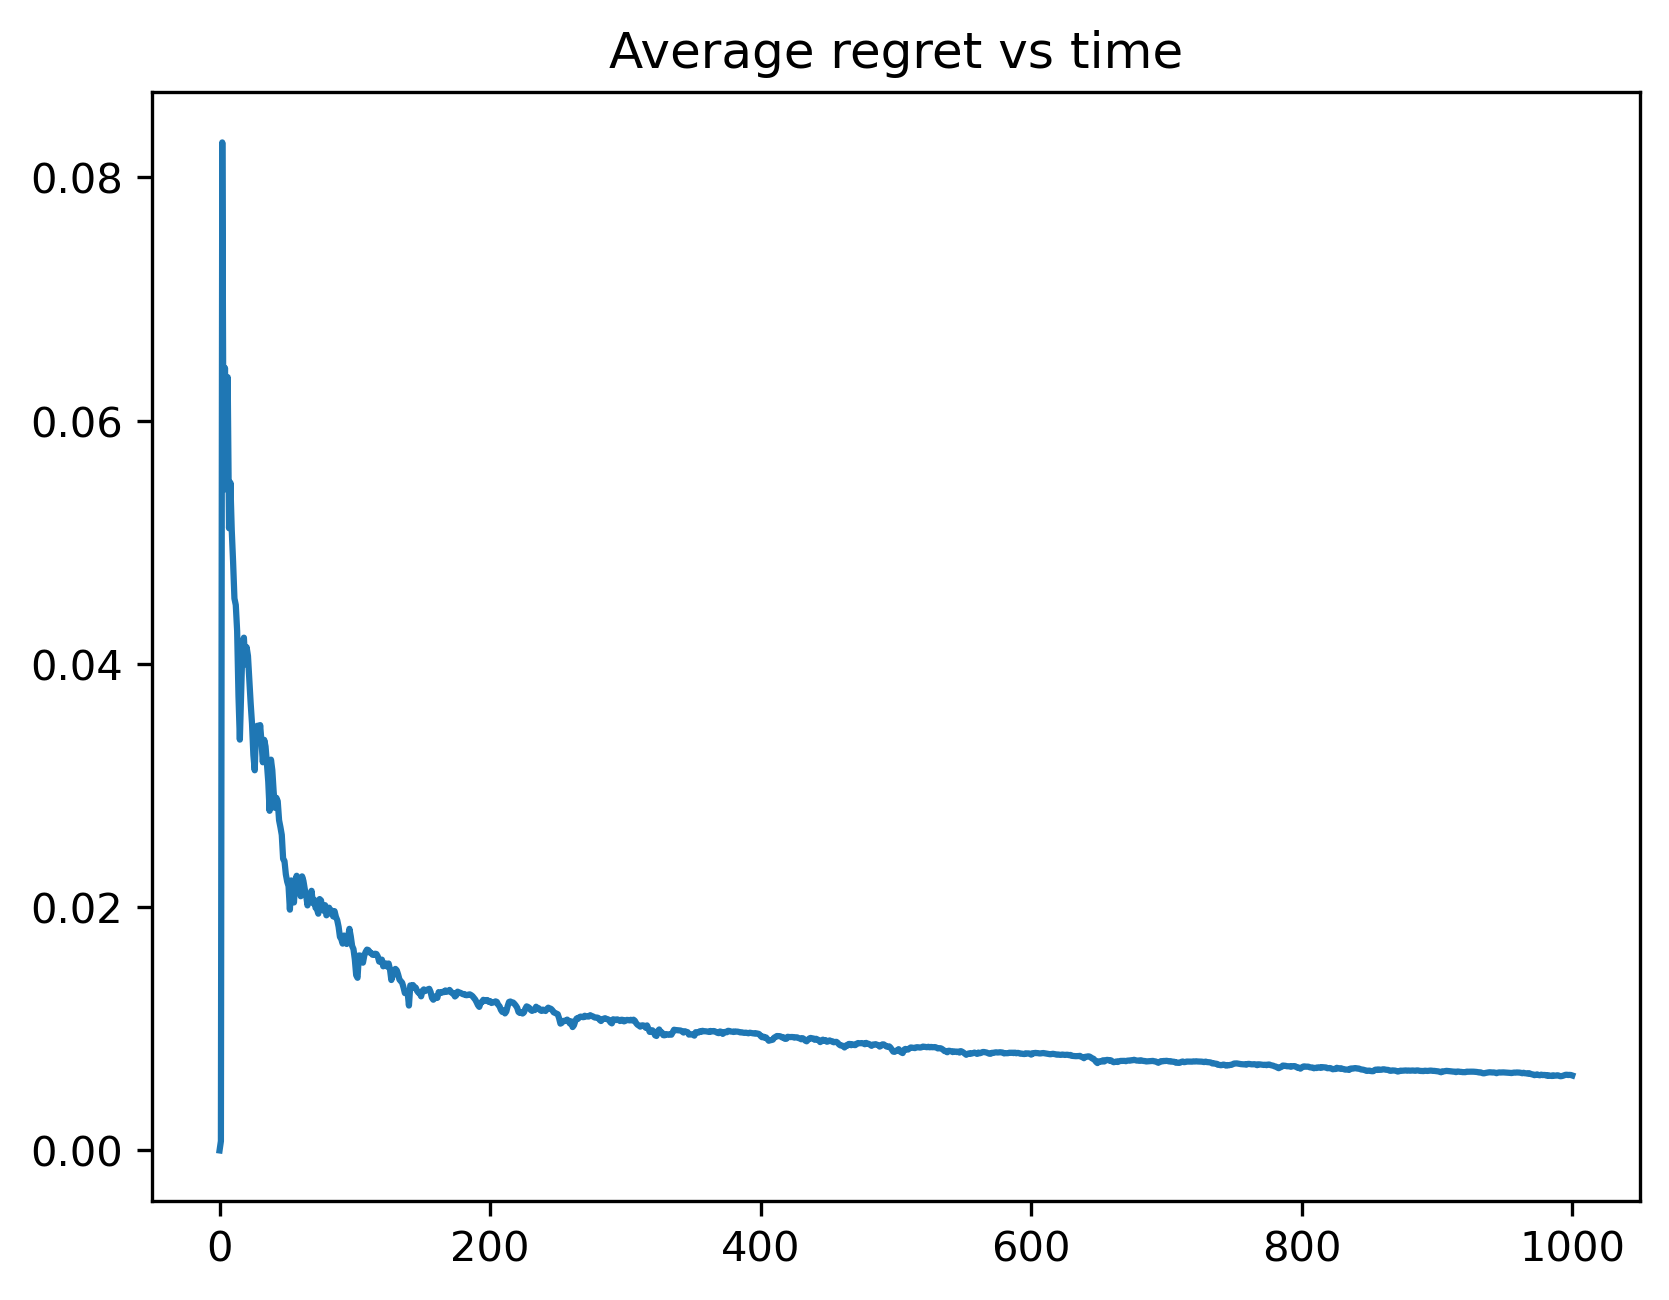

In [95]:
rolling_costs = [sum(costs[j] for j in range(i)) for i in range(len(costs))]
offline_costs = [cost(offline_x,center) for center in samples]
rolling_offline_costs = [sum(offline_costs[j] for j in range(i)) for i in range(len(offline_costs))]

plt.title("Cumulative cost against time")
plt.plot(rolling_costs,label="Greedy Projection")
plt.plot(rolling_offline_costs, label="Offline solution")
plt.xlabel("Timestep")
plt.ylabel("Cumulative cost")
plt.legend()
plt.figure()
plt.title("Regret vs. time")
plt.plot(np.array(rolling_costs)-np.array(rolling_offline_costs), label="Observed regret")
T = np.arange(0,len(costs))
plt.plot(T, ((F_norm**2)/2)*np.sqrt(T) + (np.sqrt(T)-0.5)*grad_bound**2, label="Theoretical bound (Zinkevich)")
#plt.plot(T, ((grad_bound**2))*(1+ np.log(T+1)), label="Theoretical bound (Hazan)")
plt.legend()

plt.figure()
plt.title("Average regret vs time")
plt.plot((np.array(rolling_costs)-np.array(rolling_offline_costs))/np.arange(1,seq_length+2))

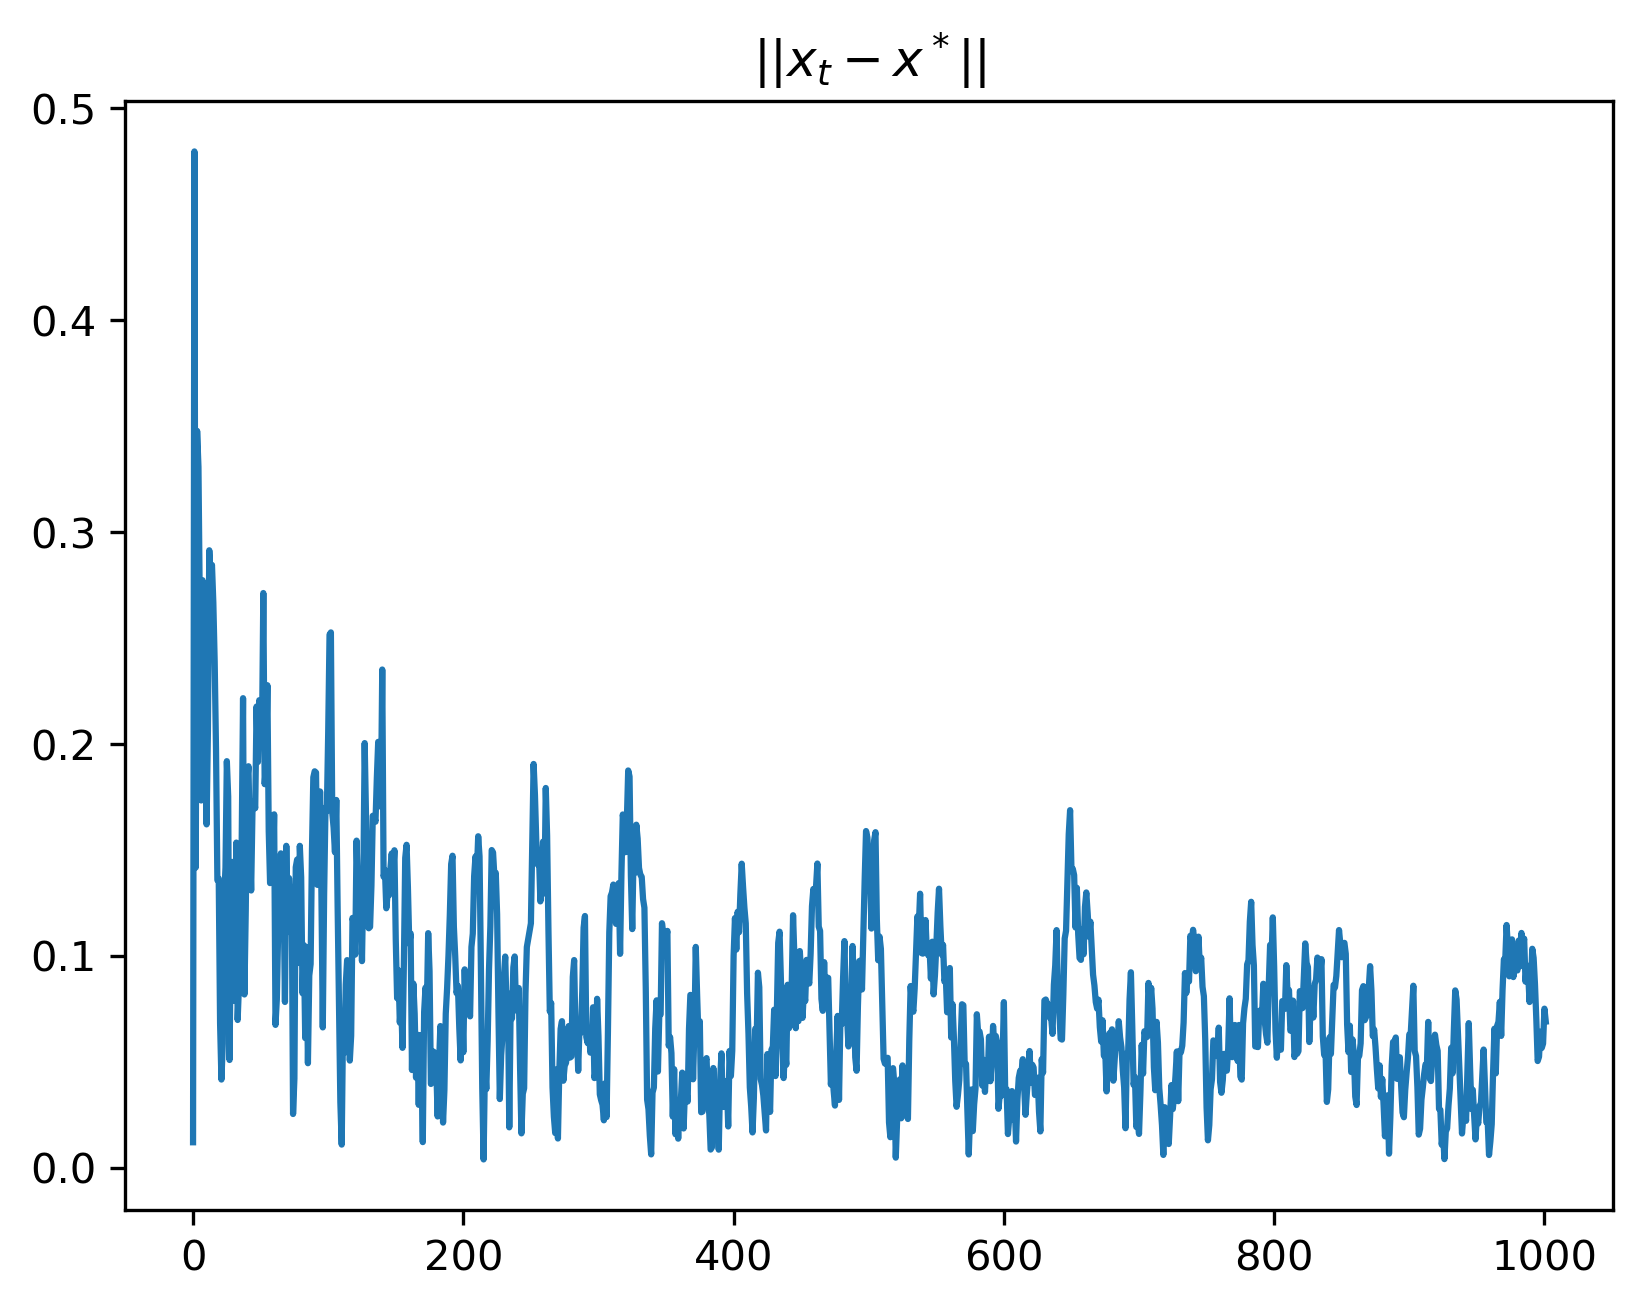

In [96]:
plt.title(r"$||x_t - x^*||$")
plt.plot([np.linalg.norm(x_t[t] - offline_x) for t in range(len(x_t))] )

In [81]:
# adversarial example
def grad(x, center):
    return (x-center)
def cost(x,center):
    return 0.5*(x-center)@(x-center)
# come up with a sequence of guesses via greedy projection
x0 = np.array([0.1,0.1])
x_t = [x0]
costs = []
last_c = np.array([-1,0])
centers = [last_c]
for t in range(100):
    # get the gradient of the given function
    this_step = 1/np.sqrt(t+1)
    last_x = x_t[-1]
    last_c = centers[-1]
    
    costs.append(cost(last_x,last_c))
    
    this_grad = grad(last_x,last_c)
    unproj_step = last_x - this_step*this_grad
    # do the projection
    result = unproj_step / max(1, np.linalg.norm(unproj_step))
    # if result.status == 0:
    #     x_t.append(result.x)
    # else:
    #     x_t.append(last_x)
    x_t.append(result)
    #if np.random.uniform() <= 0.5:
    if np.isclose(np.linalg.norm(x_t[-1]),0):
        point = np.random.normal(size=2)
        point = point/np.linalg.norm(point)
        centers.append(np.array([1,0]))
    else:
        centers.append(-x_t[-1]/np.linalg.norm(-x_t[-1]))
    #else:
    #    this_c = np.random.normal(loc=0,scale=0.5,size=2)
    #    centers.append(this_c/max(1,np.linalg.norm(this_c)))

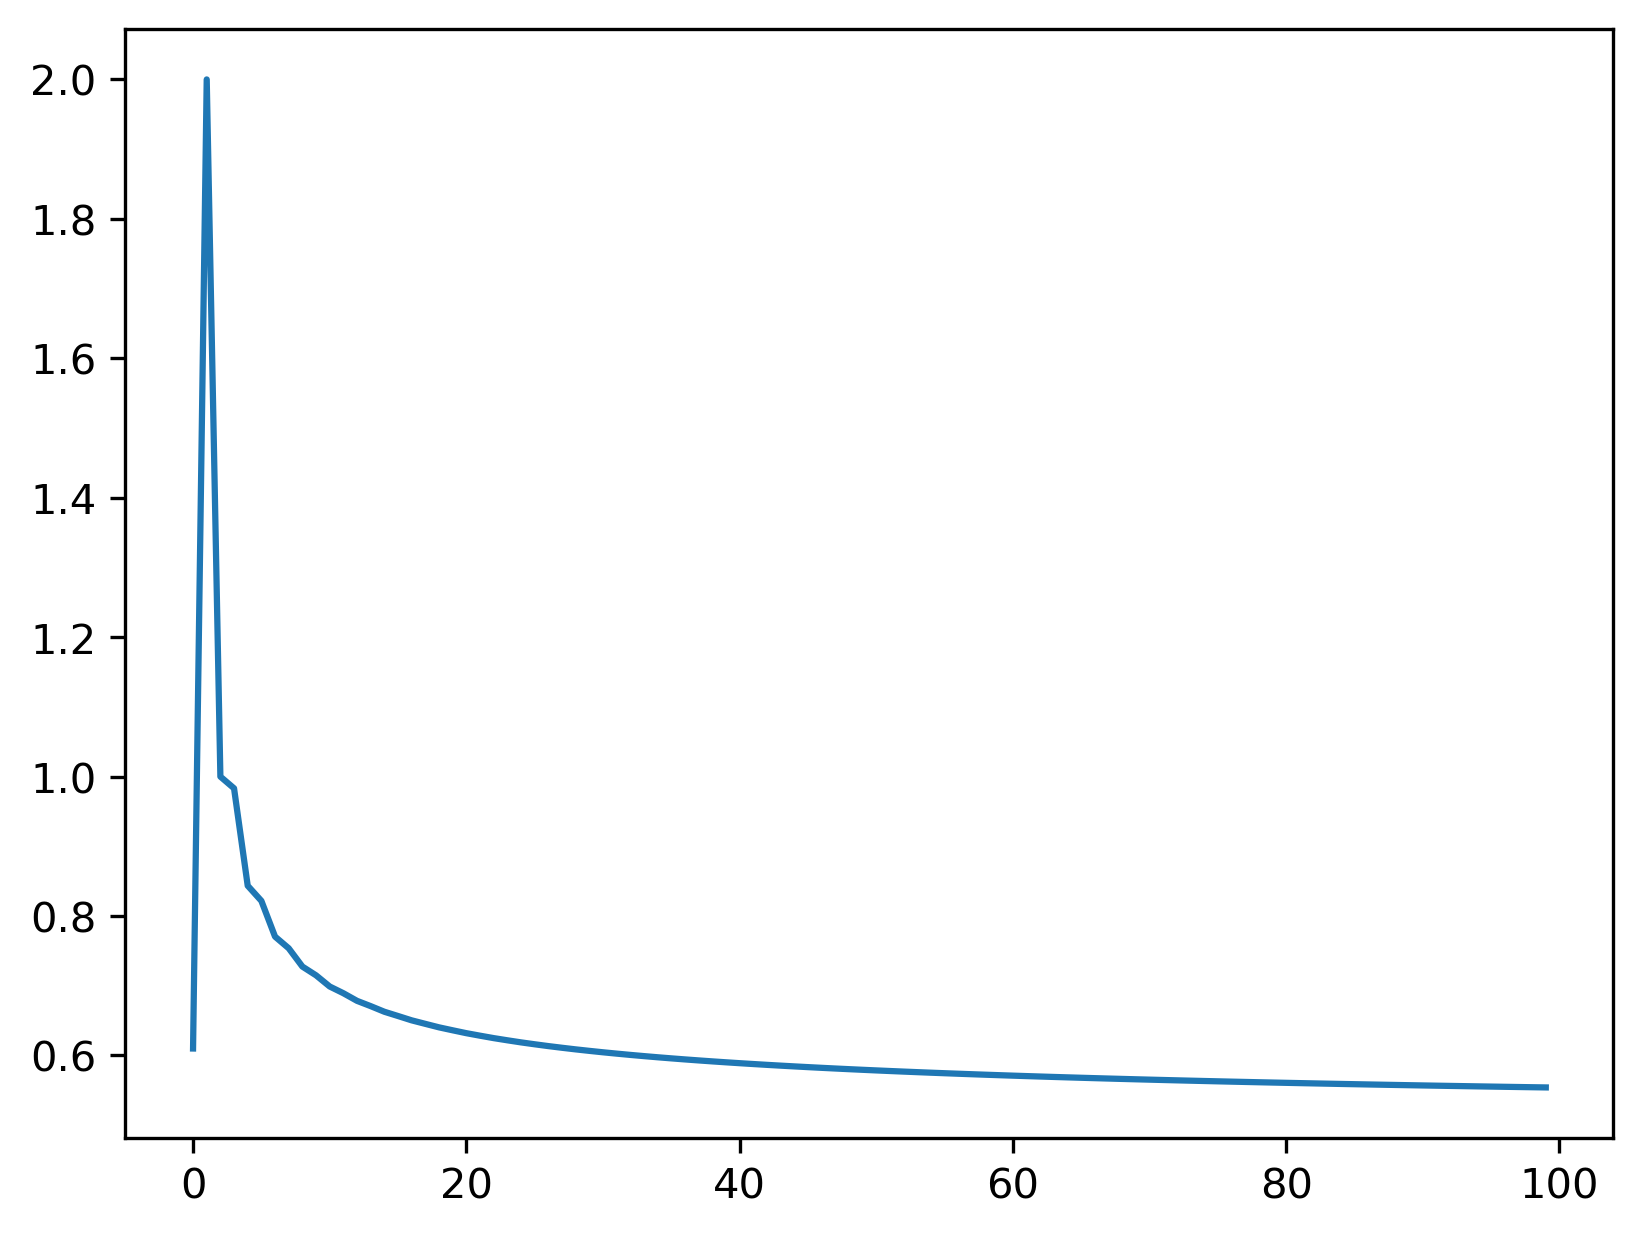

In [82]:
plt.plot(costs)

In [83]:
x_t

[array([0.1, 0.1]),
 array([-1.,  0.]),
 array([0.41421356, 0.        ]),
 array([-0.40228302,  0.        ]),
 array([0.29885849, 0.        ]),
 array([-0.28200868,  0.        ]),
 array([0.24136917, 0.        ]),
 array([-0.22782427,  0.        ]),
 array([0.20627716, 0.        ]),
 array([-0.19581523,  0.        ]),
 array([0.18233475, 0.        ]),
 array([-0.17415259,  0.        ]),
 array([0.16479607, 0.        ]),
 array([-0.15826024,  0.        ]),
 array([0.15129783, 0.        ]),
 array([-0.14596599,  0.        ]),
 array([0.14052551, 0.        ]),
 array([-0.13609256,  0.        ]),
 array([0.13168703, 0.        ]),
 array([-0.12793978,  0.        ]),
 array([0.12427522, 0.        ]),
 array([-0.12106175,  0.        ]),
 array([0.11794942, 0.        ]),
 array([-0.11515915,  0.        ]),
 array([0.11247176, 0.        ]),
 array([-0.11002259,  0.        ]),
 array([0.10767075, 0.        ]),
 array([-0.10550059,  0.        ]),
 array([0.10341939, 0.        ]),
 array([-0.10148

In [84]:
costs

[0.6100000000000001,
 2.0,
 0.9999999999999998,
 0.9831988320633439,
 0.8435166894612047,
 0.821773134155224,
 0.7704987069157002,
 0.7537762248314872,
 0.7275522941423204,
 0.7149870276527396,
 0.6989577320934245,
 0.6893171514672298,
 0.6783749393836612,
 0.6707833873024361,
 0.6627433501747564,
 0.6566190242284478,
 0.6503992172933168,
 0.6453531511828872,
 0.6403577615694598,
 0.6361240783373393,
 0.6319973840696786,
 0.6283897206367579,
 0.6249054531726012,
 0.6217899627071076,
 0.618796708250354,
 0.6160750774936536,
 0.6134672436224939,
 0.6110657732441135,
 0.6087671716830463,
 0.6066295901051338,
 0.6045836632815877,
 0.6026662895197961,
 0.6008300326598787,
 0.5990984504941551,
 0.5974384877717874,
 0.595865213611519,
 0.5943551816368078,
 0.592917999265527,
 0.5915367524734407,
 0.590217503986492,
 0.5889478529686736,
 0.5877315473681519,
 0.5865593523501735,
 0.585433498997961,
 0.5843470057920022,
 0.5833011094728947,
 0.5822904546038818,
 0.5813156283907446,
 0.5803724645

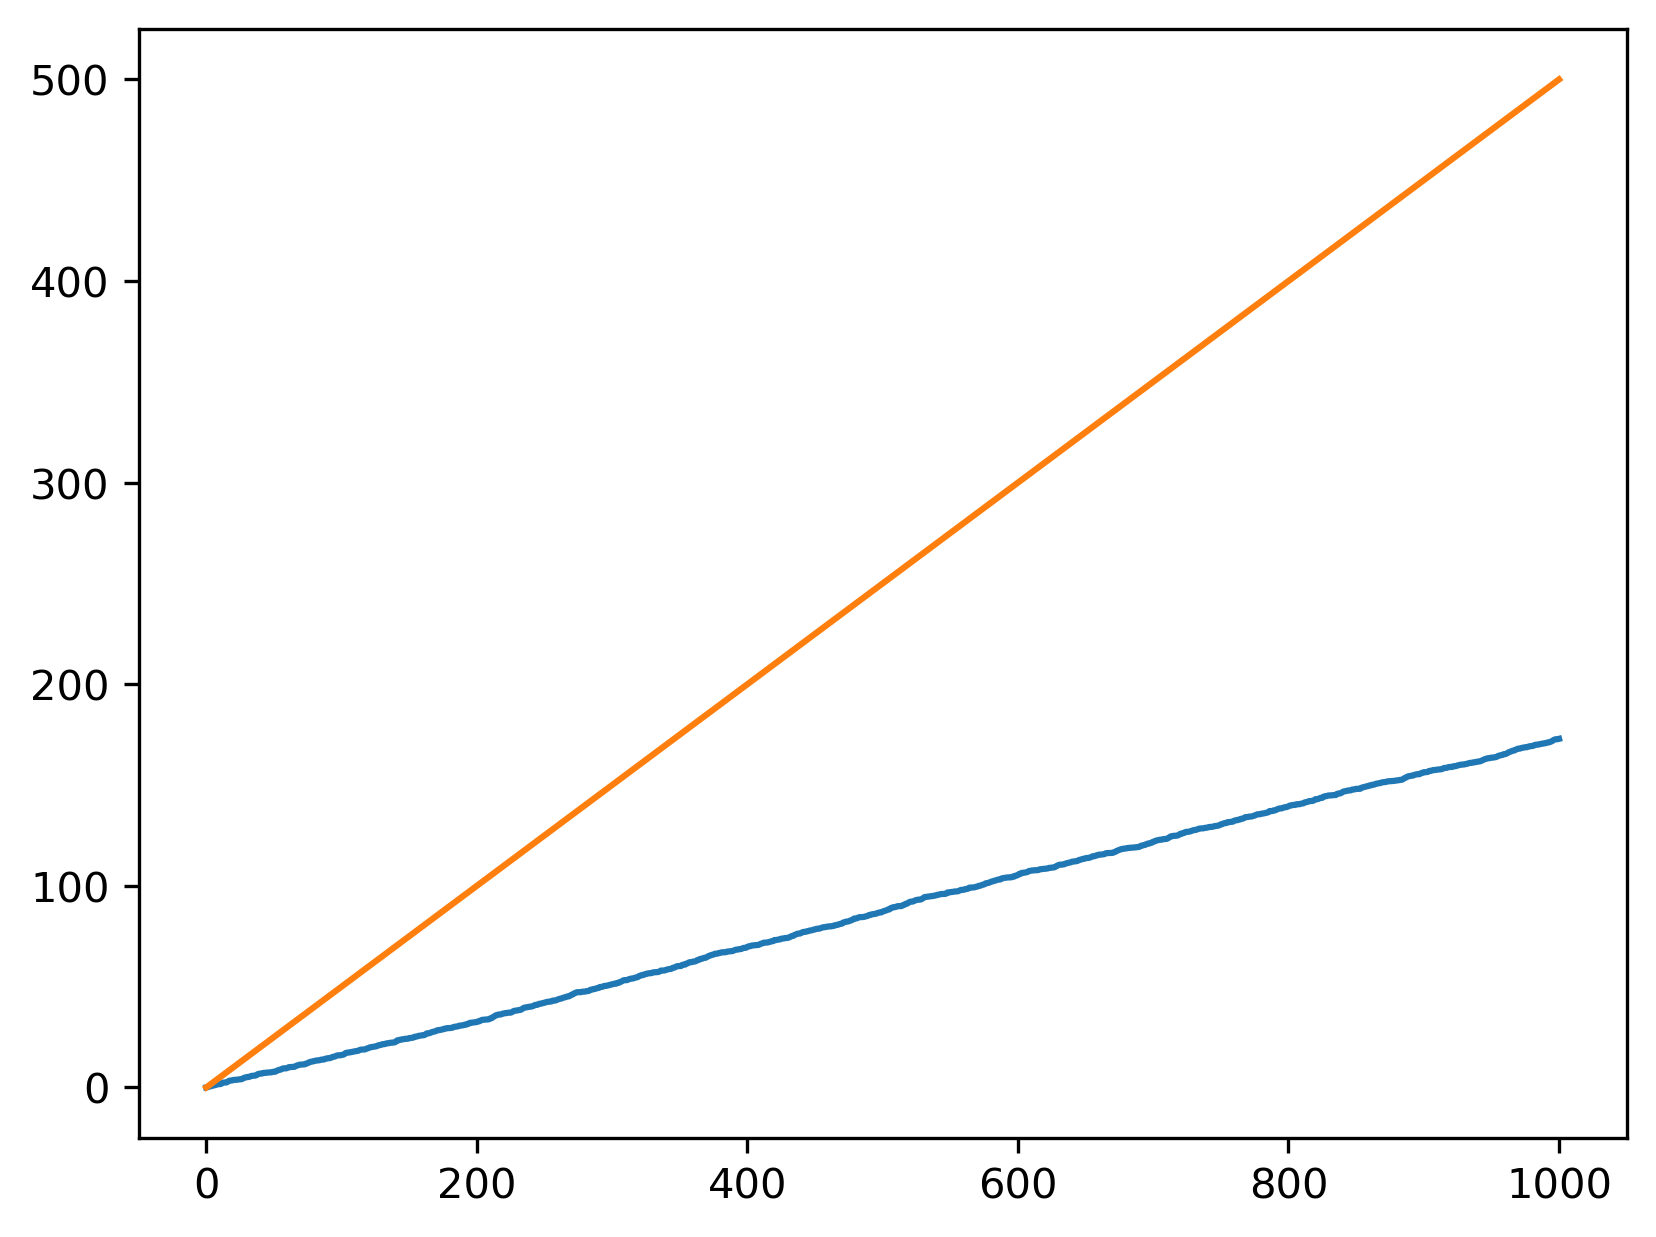

In [99]:
rolling_costs = [sum(costs[j] for j in range(i)) for i in range(len(costs))]
#plt.plot(offline_costs)
offline_costs = [ 0.5 for center in samples]
rolling_offline_costs = [sum(offline_costs[j] for j in range(i)) for i in range(len(offline_costs))]
plt.plot(rolling_costs)∥
plt.plot(rolling_offline_costs)

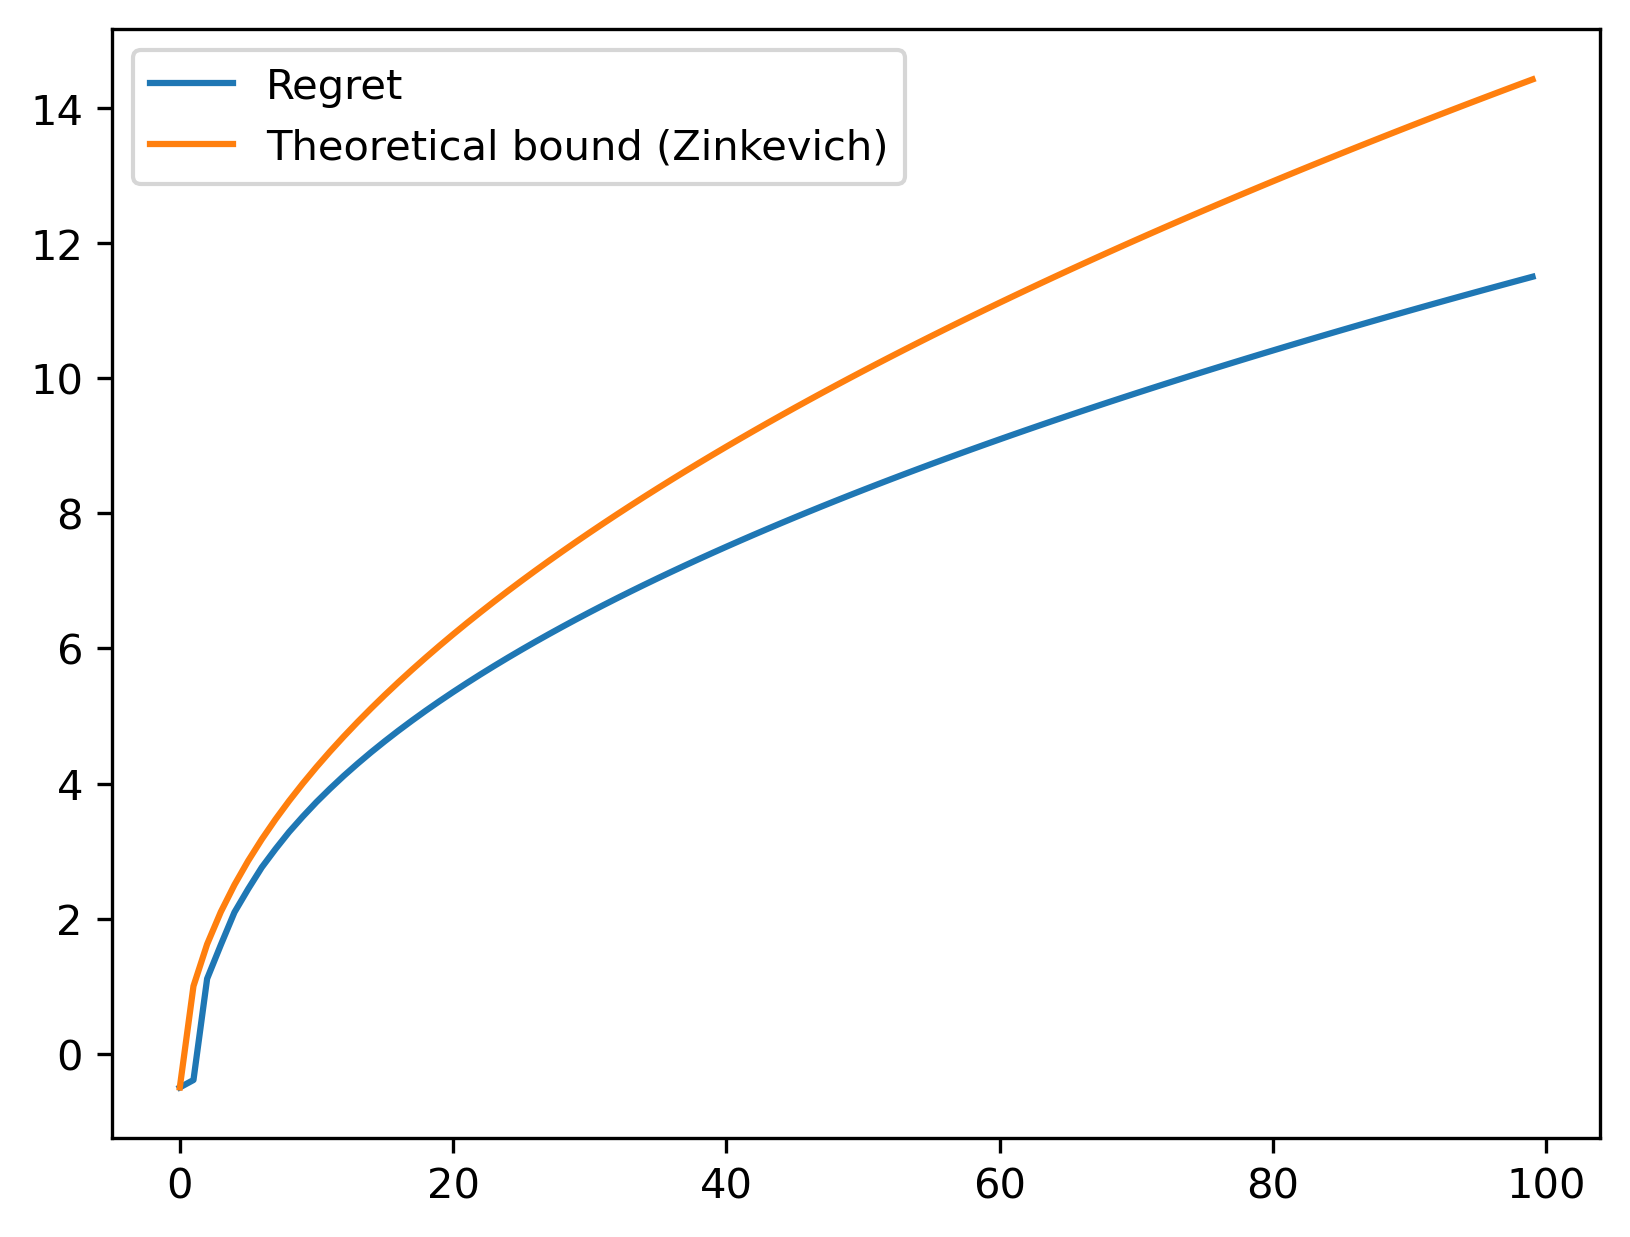

In [89]:
# stuff for the bounds
F_norm = 1
grad_bound = 1
hess_bound = 2
plt.plot(np.array(rolling_costs)-0.5*np.arange(1,len(rolling_costs)+1),label="Regret")
T = np.arange(0,len(costs))
plt.plot(T, ((F_norm**2)/2)*np.sqrt(T) + (np.sqrt(T)-0.5)*grad_bound**2, label="Theoretical bound (Zinkevich)")
plt.legend()